In [1]:
import psycopg2 as pg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re

In [2]:
%matplotlib inline

In [3]:
# Connect to psql database
conn = pg2.connect(dbname='lastfm', user='evansadler', host='/tmp')
c = conn.cursor()

In [4]:
# Query database for random sample of 10000 rows
### ALTER TABLE user_plays ADD COLUMN row_id SERIAL PRIMARY KEY;
query = 'select * from usa_plays where row_id in (select round(random() * 3.634e6)::integer as id from generate_series(1, 11000)) group by row_id limit 10000;'
df = pd.read_sql_query(query, conn)

In [ ]:
# summary statistics
df.describe()

* missing data potentially, max at 8.5 million
* outliers!
* approximatesly 24 per user (8664072/360000)
* must have distribution of heavy and light users, which is good!

In [ ]:
# Histogram
plt.hist(df.ix[df.plays < 1000, 'plays'], bins = 100)
plt.show()

* right skewed, must consider when binning
* some users could have barely used the service
 * number of listens shouldn't translate to a rating for them

In [ ]:
query = 'SELECT userid, SUM(plays) as total_plays, COUNT(*) as artists_played FROM user_plays GROUP BY userid'
df_c = pd.read_sql_query(query, conn)

In [ ]:
# Histogram
plt.hist(df_c.artists_played, bins = 100)
plt.show()

plt.hist(df_c.ix[(df_c['total_plays'] < 40000), 'total_plays'], bins = 100)
plt.show()

In [ ]:
# Get quantiles for number of artists and plays
# Get sample of users and see distribution of artist plays

In [143]:
arts = pd.Series(df_t.artist.unique()).dropna()
arts.str.contains('^\s+|^\s*.{0,2}\s*$|{.*}', 
             flags=re.IGNORECASE, regex=True, na=False).value_counts()

False    12562
True        49
dtype: int64

In [6]:
# Get all artists users in random sample

userids = list(df.userid.unique())
userids = [x for x in userids if x is not None]
#query = "SELECT * FROM usa_plays where userid IN ({0});".format(str(userids[0:3000])[1:-1])
#query = "SELECT * FROM usa_plays where userid IN ({0});".format(str(userids[0:1000])[1:-1])
query = 'SELECT * FROM sample;'
df_t = pd.read_sql_query(query, conn)

In [7]:
# Remove bunk artist names
df_at = df_t.groupby('artist')['plays'].sum().reset_index().sort('plays', ascending = False)
r = df_at.artist.str.contains('^\s*.{0,1}\s*$|{.*}|^\[.*]')
df_at.ix[r,:].T

,127,11905,64,0,1,130,2671,6545,6021,5091,11754,126,4579
artist,[unknown],x,3,,,a,d,m,l,j,w,[traditional],h
plays,3398,1026,880,837,740,401,238,188,96,84,68,8,2


In [17]:
df_at.describe().T

,count,mean,std,min,25%,50%,75%,max
plays,23761,1492.515509,7206.313893,1,57,185,655,411123


These all look pretty bad. Some could be missing non-ascii characters that I removed before importing to postgres, but it will reduce total bands by a few thousand on the entire dataset, with most being bad. 

In [8]:
# remove bands from df_t

df_t = df_t.ix[~df_t['artist'].isin(list(df_at.ix[r,:]['artist'])),:]

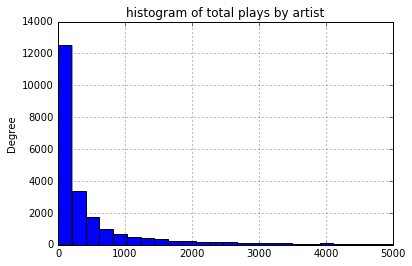

In [19]:
# totals by artist

df_at.plays.plot(kind='hist', title='histogram of total plays by artist', bins = 2000)
plt.xlim([0,5000])
plt.show()

In [270]:
def kdes(df, grouped_col, plotted_col):
    
    df_new = df.groupby(grouped_col)[plotted_col].max().reset_index()
    print df_new.describe().T
    df_new.plot(kind='kde', title = 'kde of max')
    plt.xlim([0,2000])
    plt.show()
    
    df_new = df.groupby(grouped_col)[plotted_col].min().reset_index()
    print df_new.describe().T
    df_new.plot(kind='kde', title = 'kde of min')
    plt.xlim([0,2000])
    plt.show()
    
    df_new = df.groupby(grouped_col)[plotted_col].mean().reset_index()
    print df_new.describe().T
    df_new.plot(kind='kde', title = 'kde of mean')
    plt.xlim([0,2000])
    plt.show()

       count      mean          std  min     25%  50%   75%    max
plays   1000  1356.289  2244.620807    4  307.75  714  1431  29324


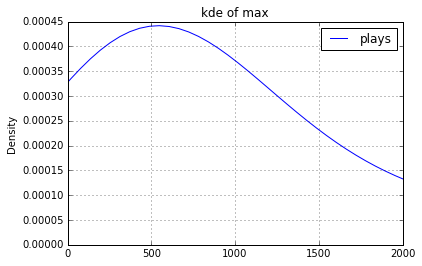

       count   mean         std  min    25%  50%     75%   max
plays   1000  98.49  133.845286    1  24.75   62  122.25  1477


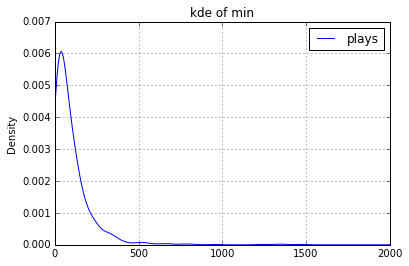

       count        mean         std       min        25%         50%  \
plays   1000  254.708234  309.875295  1.404762  74.807551  163.048772   

              75%          max  
plays  317.297832  3523.333333  


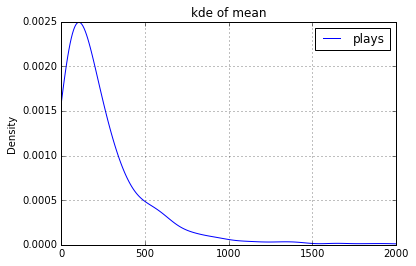

In [325]:
kdes(df_t, 'userid','plays')

In [9]:
df_piv = df_t.groupby(['userid','artist'])['plays'].mean().reset_index().pivot(index = 'userid', columns = 'artist', values = 'plays')

In [10]:
df_piv = df_piv.fillna(0)

In [ ]:
# Cross tab in psql

artists = list(df_t['artist'])
s = ''
for artist in artists:
    s += ',"' + str(artist) + '"int'
query = "select * from crosstab('select userid, artist, plays from sample order by userid','select artist as name from sample') as (row_name text" + s + ");"

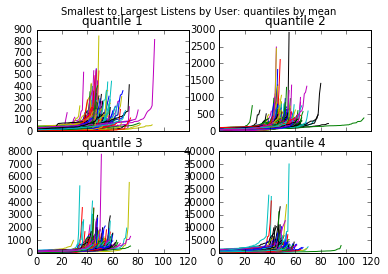

count    1000.000000
mean      249.638981
std       356.736431
min         1.708333
25%        69.111551
50%       155.514674
75%       309.543451
max      5590.709091
Name: mean, dtype: float64


In [74]:
qp = quantilePlot(df_t, 'userid','plays')
qp.plot_quantiles('mean')

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score
from pymongo import MongoClient
import re

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


class ReduceFeatures(object):
    def __init__(self, df, names):
        '''
            Set self.names and do preprocess data for dimension
            reduction.
        '''
        self.df = df
        self.crimes = df.columns
        self.names = names

    def fit_pca(self, n_components):
        pca = PCA(n_components = n_components)
        self.X = pca.fit_transform(self.X)
        self.df_c = pd.DataFrame(pca.components_.T, index = self.crimes, columns = range(1,n_components + 1))

        print pca.explained_variance_ratio_
        return self.df_c


    def sparse_pca(self, n_components, alpha):
        pca = SparsePCA(n_components = n_components, alpha = alpha)
        self.X = pca.fit_transform(self.X)
        self.df_c = pd.DataFrame(pca.components_.T, index = self.crimes, columns = range(1,n_components + 1))
        

        return self.df_c

    def preprocessing(self, non_na_thresh = None):
        if non_na_thresh == None:
            non_na_thresh = len(self.df)
        mask = (self.df.dtypes == np.float64) | (self.df.dtypes == np.int)
        df_sub = self.df.ix[:, mask]
        df_sub = df_sub.dropna(axis = 1, thresh = non_na_thresh)
        #df_sub = df_sub.fillna(0)
        imp = preprocessing.Imputer(axis=0)
        X = imp.fit_transform(df_sub)
        X_centered = StandardScaler().fit_transform(X)

        self.X = X_centered
        self.crimes = df_sub.columns.values


    def hcluster_cols(self, thresh):
        try:
            link = linkage(self.X.T, method='complete', metric = 'cosine')
            assignments = fcluster(link, thresh, 'distance')

        except:
            link = linkage(self.X.T, method='complete', metric = 'euclidean')
            assignments = fcluster(link, thresh, 'distance')

        col_ind = np.arange(len(self.crimes))
        d = pd.DataFrame(zip(col_ind, assignments)).groupby(1)[0].aggregate(lambda x: tuple(x))
        df_new = pd.DataFrame(index = np.arange(len(self.names)))
        for i in d:
            cols = []
            for w in i:
                cols.append(w)
            if len(cols) > 1:
                df_new[str(self.crimes[cols])] = np.mean(self.X[:,cols], axis = 1)
            else:
                df_new[str(self.crimes[cols[0]])] = self.X[:,cols[0]]

        # plt.figure(figsize=(10,20))
        # dendro = dendrogram(link, color_threshold=thresh, leaf_font_size=13, labels = self.crimes, orientation = 'left')
        # plt.subplots_adjust(top=.99, bottom=0.5, left=0.05, right=0.99)
        # plt.show()

        self.df = df_new
        self.crimes = df_new.columns.values

    def best_cluster(self, n_cluster_list):
        best = (0,0, 0)
        for i in n_cluster_list:
            clusterer = KMeans(n_clusters=i)
            cluster_labels = clusterer.fit_predict(self.X)
            silhouette_avg = silhouette_score(self.X, cluster_labels)
            if abs(silhouette_avg) > best[1]:
                best = i, silhouette_avg, cluster_labels
            print "For n_clusters =", i, "The average silhouette_score is :", silhouette_avg
        self.best = best


    def plot_embedding(self, dimensions):
        y = self.best[2]
        X =  StandardScaler().fit_transform(self.X)
        
        

        if dimensions == 3:
            fig = plt.figure(figsize = (12,12), dpi=250)
            ax = fig.add_subplot(111,projection='3d')

            for i in range(X.shape[0]):
                ax.text(X[i, 0], X[i, 1],X[i,2], str(self.names[i][0:15]), color=plt.cm.Set1(y[i] / 10.), fontsize = 8)
            
            ax.set_xlim3d(X[:,0].min(), X[:,0].max())
            ax.set_ylim3d(X[:,1].min(), X[:,1].max())
            ax.set_zlim3d(X[:,2].min(), X[:,2].max())
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            plt.show()
        elif dimensions == 2:
            plt.figure(figsize=(12, 12), dpi=250)
            ax = plt.subplot(111)

            for i in range(X.shape[0]):
                ax.text(X[i, 0], X[i, 1], str(self.names[i][0:15]), color=plt.cm.Set1(y[i] / 10.), fontsize = 8)
            
            ax.set_xlim(X[:,0].min(), X[:,0].max())
            ax.set_ylim(X[:,1].min(), X[:,1].max())
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            plt.show()            

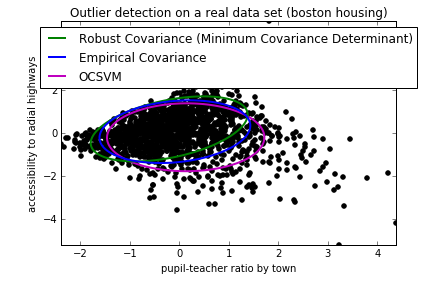

In [334]:
# Author: Virgile Fritsch <virgile.fritsch@inria.fr>
# License: BSD 3 clause

import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = rf.X

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(X1[:,0].min(), X1[:,0].max(), 500), np.linspace(X1[:,1].min(),  X1[:,1].max(), 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list( legend1.values() )
legend1_keys_list = list( legend1.keys() )

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list( legend2.values() )
legend2_keys_list = list( legend2.keys() )



plt.show()

In [68]:
class quantilePlot(object):
    def __init__(self, df, by_col, value_col):
        self.by_col = by_col
        self.value_col = value_col


        self.metrics  = ['sum', 'mean', 'count', 'max', 'min']

        self.df = self.compute_quantiles(df)

        grouped = df.groupby(self.by_col)
        self.df_g = grouped.aggregate(lambda x: list(x)).reset_index()


    def compute_quantiles(self, df):
        f = {self.value_col: self.metrics}
        return df_t.groupby('userid').agg(f).reset_index()


    def plot_quantiles(self, metric):
        f, ax = plt.subplots(2, 2,sharex=True)

        coords = [[0,0],[0,1],[1,0],[1,1]]
        for ind, i in enumerate([[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1]]):
            df_q = self.df.ix[(self.df[self.value_col][metric] < self.df[self.value_col][metric].quantile(i[1])) & \
                              (self.df[self.value_col][metric] > self.df[self.value_col][metric].quantile(i[0])),:]
            percentile = set(df_q.userid)
            ax[coords[ind][0], coords[ind][1]].set_title('quantile ' + str(ind + 1))
            for i in xrange(len(self.df_g)):
                x = self.df_g.ix[i,:]
                if x['userid'] in percentile:
                    ax[coords[ind][0], coords[ind][1]].plot(range(len(x['plays'])),sorted(x['plays']))

        f.suptitle('Smallest to Largest Listens by User: quantiles by ' + metric)
        plt.show()
        print self.df[self.value_col][metric].describe().T

In [449]:
#df_piv = df_t.groupby(['userid','artist'])['plays'].mean().reset_index().pivot(index = 'userid', columns = 'artist', values = 'plays')
summary = df_piv.dropna(thresh=10)

In [450]:
summary = df_piv.dropna(thresh=10).describe()

In [451]:
summary = summary.T

In [452]:
skew = summary.skew(axis=1)
kurtosis = summary.kurtosis(axis=1)



In [455]:
summary['skew'] = skew
summary['kurtosis'] = kurtosis



For n_clusters = 10 The average silhouette_score is : 0.628095956276


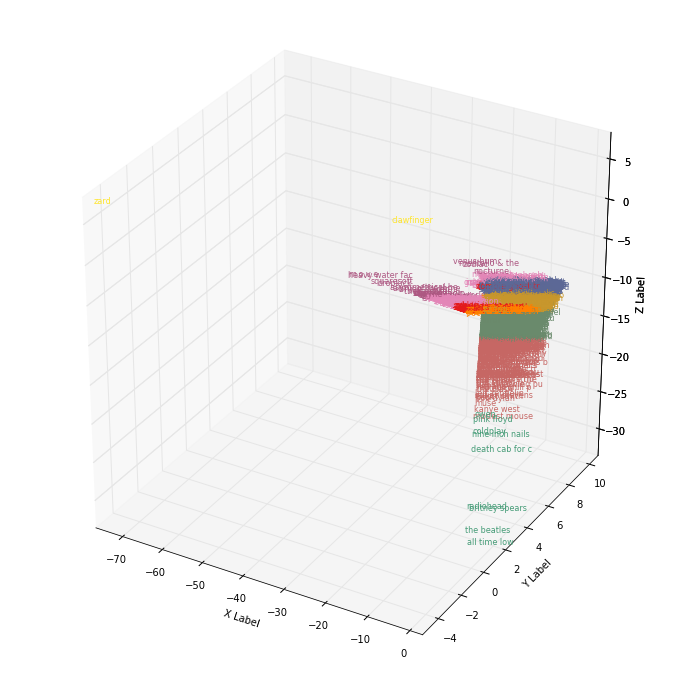

In [456]:
rf = ReduceFeatures(summary, summary.index)
rf.preprocessing()
# rf.hcluster_cols(0.1)
# rf.preprocessing()

df_up = rf.sparse_pca(3, 3)
rf.best_cluster([10])

rf.plot_embedding(3)


In [118]:
summary['cluster'] = rf.best[2]

In [126]:
users = summary.ix[~summary.cluster.isin([3,4,8,6,5]), :].index

In [130]:
better = df_piv.ix[df_piv.index.isin(users),:]

In [10]:
#df_piv = df_piv.T.dropna(thresh= 20).T
df_piv = df_piv[df_piv < 1000]

In [11]:
summary = df_piv.T.dropna(thresh=70)

# skew = summary.skew(axis=1)
# kurtosis = summary.kurtosis(axis=1)


In [393]:
summary = summary.T.describe()

In [394]:
summary = summary.T



In [395]:
summary['skew'] = skew
summary['kurtosis'] = kurtosis



In [396]:
summary = summary.dropna()

For n_clusters = 8 The average silhouette_score is : 0.299793731821


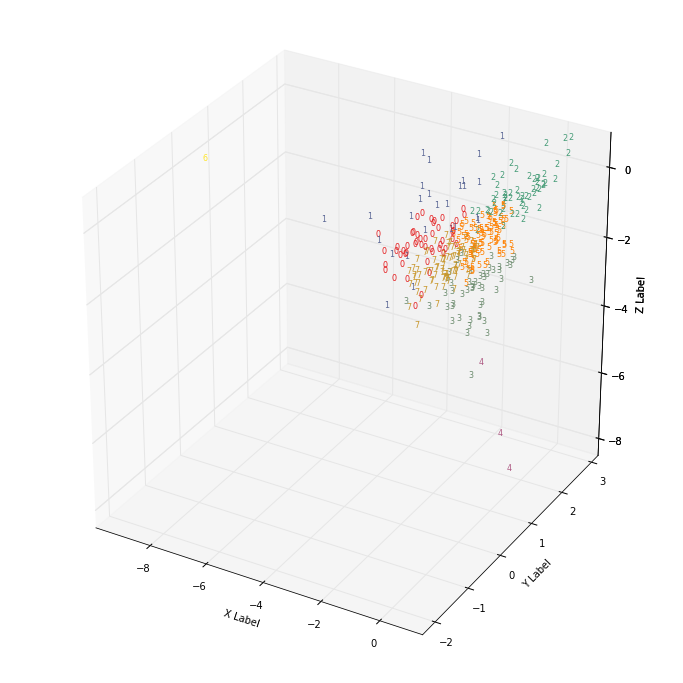

In [397]:
rf = ReduceFeatures(summary, summary.index)
rf.preprocessing()
# #rf.hcluster_cols(0.1)

df_up = rf.sparse_pca(3, 8)
rf.best_cluster([8])

rf.plot_embedding(3)


In [419]:
summary.ix[summary.index.str.match('brit'),:]

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
britney spears,175,650.32,4528.321999,7,56,134,286.5,59758,12.933153,169.636181


In [409]:
summary.ix['the beatles',:]

count        993.000000
mean         414.021148
std          638.134536
min            2.000000
25%           83.000000
50%          202.000000
75%          463.000000
max         7556.000000
skew           4.569971
kurtosis      32.656751
Name: the beatles, dtype: float64

In [253]:
better = better.dropna(thresh=70, axis=1)

In [254]:
better = better.fillna(0)

In [252]:
better[better == 0] = np.nan

In [382]:
rf = ReduceFeatures(better, better.index)
# rf.preprocessing()
# rf.hcluster_cols(0.9)
rf.preprocessing()

df_up = rf.sparse_pca(7,8)
rf.best_cluster([10])

# rf.plot_embedding(3)


For n_clusters = 10 The average silhouette_score is : 0.590540063145


array([0, 0, 0, ..., 6, 0, 0], dtype=int32)

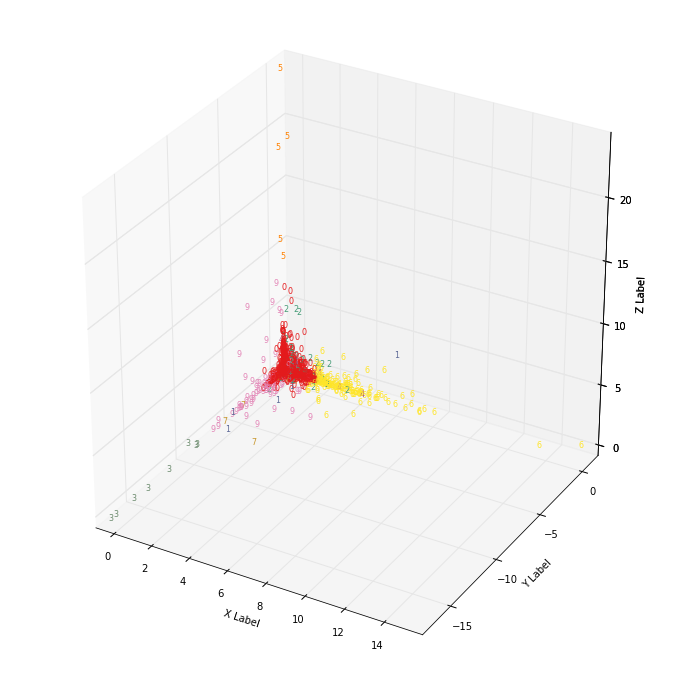

In [391]:
rf.plot_embedding(3)

In [372]:
df_up.sort(6, ascending = False)



,1,2,3,4,5,6,7,8
something corporate,0.000000,0.000000,0.000000,0.000000,0,33.524695,0.000000,0
the format,0.000000,0.000000,0.000000,0.000000,0,29.477243,0.000000,0
jimmy eat world,0.000000,0.000000,0.000000,0.000000,0,28.577601,0.000000,0
brand new,0.000000,0.000000,0.000000,0.000000,0,23.116060,0.000000,0
new found glory,0.000000,0.000000,0.000000,0.000000,0,18.612197,0.000000,0
dashboard confessional,0.000000,0.000000,0.000000,0.000000,0,14.702670,0.000000,0
hellogoodbye,0.000000,0.000000,0.000000,0.000000,0,8.660784,0.000000,0
taking back sunday,0.000000,0.000000,0.000000,0.000000,0,8.512305,0.000000,0
saves the day,0.000000,0.000000,0.000000,0.000000,0,6.733267,0.000000,0
say anything,0.000000,0.000000,0.000000,0.000000,0,6.518041,0.000000,0


artist,(big bang),(sugar),......,paradis,paradis & nov svt,!!!,!attention!,!deladap,!t.o.o.h.!,#poundsign#,...,zox,zpu,zu,zuboly,zuntata,zwan,zyklon,zz,zz top,zzt
userid,,,,,,,,,,,,,,,,,,,,,
000701c3c006b091990162635b36b008c504c6a7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000d109e4a25299eeef77a14d6b6a81479d1ac0e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000d8c54934cc3a9eab276ccb412dbf52b980a44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0056071d50398fcc4ccd367904ea5274103b4719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005a5423f3d0a583a8da1713b3ace4bde5ff6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_test = summary.T.fillna(0)

In [74]:
from scipy.cluster.hierarchy import linkage, fcluster

link = linkage(df_test.ix[0:100,0:100].T, method='complete', metric='cosine')
assignments = fcluster(link, 0.9, 'distance')

col_ind = np.arange(len(df_test.columns[0:100]))
d = pd.DataFrame(zip(col_ind, assignments)).groupby(1)[0].aggregate(lambda x: tuple(x))
df_new = pd.DataFrame(index=np.arange(len(df_test.columns[0:100])))
for i in d:
    cols = []
    for w in i:
        cols.append(w)
    if len(cols) > 1:
        df_new[str(df_test.columns[cols])] = np.mean(df_test.ix[0:100,0:100].ix[:, cols], axis=1)
    else:
        df_new[str(df_test.columns[cols[0]])] = df_test.ix[0:100,0:100].ix[:, cols[0]]


In [76]:
mat = np.zeros((len(df_test), len(dic)))
names = []

X = df_test.values
for k, v in dic.iteritems():
    names.append(str(list(df_test.columns[v])))
    mat[:,k] = np.mean(X[:,v], axis=1)

In [78]:
from collections import defaultdict 

link = linkage(df_test.ix[0:100,0:100].T, method='complete', metric='cosine')



dic = defaultdict(list)



for a,i in zip(assignments - 1, col_ind):
    dic[a].append(i)

    
mat = np.zeros((len(df_test), len(dic)))
names = []

X = df_test.values
for k, v in dic.iteritems():
    names.append(str(list(df_test.columns[v])))
    mat[:,k] = np.mean(X[:,v], axis=1)

,"['elliott smith', 'iron & wine', 'jack johnson', 'pink floyd', 'the decemberists', 'the shins', 'the white stripes']","['feist', 'kanye west']","['sigur rs', 'the strokes']","['david bowie', 'nirvana', 'the cure', 'the smiths']","['beck', 'green day', 'modest mouse', 'muse', 'the smashing pumpkins']","['bob dylan', 'daft punk', 'gorillaz', 'spoon', 'the rolling stones']","['death cab for cutie', 'of montreal', 'sufjan stevens', 'the postal service']","['animal collective', 'arcade fire', 'mgmt', 'radiohead', 'ratatat', 'the killers']","['beastie boys', 'bright eyes']","['led zeppelin', 'nine inch nails', 'the clash']","['belle and sebastian', 'coldplay', 'red hot chili peppers', 'the beatles']","['blink-182', 'brand new', 'fall out boy']",['regina spektor'],"['jimmy eat world', 'linkin park']",['air']
0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0,202.5,0
1,0.857143,0.0,0.0,0.00,0.0,3.4,0.00,0.000000,0.0,0.666667,0.00,0.000000,0,0.0,0
2,0.000000,0.0,0.0,157.50,71.2,0.0,102.75,43.500000,0.0,0.000000,141.25,0.000000,0,0.0,0
3,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0,622.5,0
4,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0,54.5,0
5,0.000000,0.0,0.0,0.00,0.0,22.2,0.00,0.000000,0.0,89.333333,0.00,0.000000,0,0.0,0
6,0.000000,26.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0,0.0,0
7,41.000000,0.0,0.0,0.00,0.0,21.6,0.00,0.000000,74.5,0.000000,0.00,49.666667,0,0.0,0
8,18.714286,46.5,0.0,0.00,39.6,0.0,0.00,139.833333,0.0,0.000000,26.50,0.000000,0,0.0,187
9,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0,0.0,0
